# **AI-Powered Maestro Finder: End-to-End Composer Classification on Classical MIDI**


## **LSTM modeling for composer identification**

This notebook builds a sequence model that predicts the composer from a stream of MIDI events. An LSTM is a recurrent neural network that keeps track of what came before. That makes it a good fit for MIDI, where the order and timing of events matter.

**Why LSTM is useful for our case**

An LSTM reads tokens one by one and updates an internal memory. It can learn patterns like typical intervals, cadences, and rhythmic habits that unfold across time.

**How we use it with MIDI**

We work with the event features produced in the data wrangling notebook. Each piece is a list of tokens drawn from a small vocabulary: time-shift steps, note-on, and note-off. Events are already quantized to fixed time steps and trimmed to a maximum length.

**Notebook Steps:**

* Load the manifest and the event token files.
* Build the dataset: pad or truncate sequences to a fixed length, create train and validation splits, and batch them.
* Define the model: token embedding, one or more LSTM layers, a pooled sequence representation, and a softmax layer over the composers.
* Train with cross-entropy loss and Adam. Track validation loss and accuracy. Use early stopping and model checkpoints.
* Evaluate: report accuracy per composer and a confusion matrix.
* Save the trained weights, the label map, and the exact preprocessing settings.



In [4]:
# ----------------- Standard‑library imports -----------------

import hashlib
import itertools
import json
import logging
import os
import pickle
import random
import shutil
import warnings
from pathlib import Path
import csv
import pathlib

#  ----------------- Third‑party / external packages -----------------
import keras_tuner as kt
import matplotlib.pyplot as plt
import miditoolkit
import music21
import math
import numpy as np
import pandas as pd
import pretty_midi as pm
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as L
from tqdm import tqdm

# ----------------- Global warning filters -----------------
warnings.filterwarnings("ignore",
                        category=UserWarning,
                        module="pretty_midi")
warnings.filterwarnings("ignore",
                        category=UserWarning,
                        module="mido")
warnings.filterwarnings("ignore",
                        category=RuntimeWarning,
                        module="pretty_midi")
warnings.filterwarnings("ignore",
                        category=RuntimeWarning,
                        module="mido")
warnings.filterwarnings("ignore",
                        message="Tempo, Key or Time signature",
                        category=RuntimeWarning)


In [5]:
# Mount Drive:
drive.mount('/content/drive')

# Set paths:
from pathlib import Path
ROOT      = Path("/content/drive/My Drive/maestro_data")
FEAT_DIR  = ROOT / "feat_cache"              # .pr.npy / .ev.json / .ch.pkl
MANIFEST  = ROOT / "feature_manifest.csv"    # index CSV

# Load the manifest:
import pandas as pd
df = pd.read_csv(MANIFEST)
print(f"Manifest rows: {len(df):,}")
df.head()

Mounted at /content/drive
Manifest rows: 3,430


,stem,composer
0,/content/feat_cache/Beethoven/Symphony n4 2mov...,Beethoven
1,/content/feat_cache/Beethoven/Sonata op78 1st ...,Beethoven
2,/content/feat_cache/Beethoven/Symphony op93 n8...,Beethoven
3,/content/feat_cache/Beethoven/Bagatella op33 n3,Beethoven
4,/content/feat_cache/Beethoven/Hess073 Bagatell...,Beethoven


## **Train/Val/Test Split**

Alright, here we'll Make a stratified 70 / 15 / 15 split and save three CSVs for repeatable loaders.

In [6]:
ROOT = Path("/content/drive/My Drive/maestro_data")
MANIFEST = ROOT / "feature_manifest.csv"


# 70 / 15 / 15 stratified split:
train, temp  = train_test_split(
    df, test_size=0.30, stratify=df["composer"], random_state=1981)

val,   test  = train_test_split(
    temp, test_size=0.50, stratify=temp["composer"], random_state=1981)

# save splits so any notebook can reuse them:
train.to_csv(ROOT / "split_train.csv", index=False)
val.to_csv  (ROOT / "split_val.csv",   index=False)
test.to_csv (ROOT / "split_test.csv",  index=False)

print("Saved train/val/test CSVs under", ROOT)

Saved train/val/test CSVs under /content/drive/My Drive/maestro_data


In [8]:
# make a fast local mirror of *all* composers:
!mkdir -p /content/temp_cache
!cp -r "$ROOT/feat_cache/." /content/temp_cache/

In [9]:
%%bash
# count piano-roll features per composer:
for c in Bach Beethoven Chopin Mozart; do
  echo -n "$c : "
  find "/content/temp_cache/$c" -name '*.pr.npy' | wc -l
done

Bach : 863
Beethoven : 861
Chopin : 736
Mozart : 970


## **Data loaders**

We build fast TensorFlow data pipelines that read the cached features and feed them to the model. The loaders work from the manifest CSVs, remap paths to a local mirror for speed, and return batched tensors ready for training.

**What this section sets up**

* A local cache path so reads are fast.
* Fixed shapes for each feature:
  * piano-roll: 512 time steps x 88 keys
  * event tokens: sequence length 2048
* Small helpers that map paths in the CSV to the local cache.

**Piano-roll loader**

We read `split_*.csv`, point each row to its `.pr.npy`, and filter out missing files. A generator loads one NumPy file at a time and yields a tensor of shape `(512, 88, 1)` with the integer label. The dataset shuffles (for training only), then batches and prefetches for throughput.

**Token loader**

We read the same splits but load `.ev.json` event lists. Each sequence is padded or truncated to length `2048` using `0` as the pad id. The generator yields an `int32` array and its label. We again batch and prefetch.

**Train, validation, and test sets**

We instantiate three datasets for each modality:
* `train_roll`, `val_roll`, `test_roll` for the piano-roll CNN pathway
* `train_tok`, `val_tok`, `test_tok` for the LSTM event pathway



In [10]:
# ----------------------- NEW base folder (local, fast) -----------------------
# All feature files were copied here
LOCAL_CACHE = Path("/content/temp_cache")
OLD         = "/content/feat_cache"
NEW         = str(LOCAL_CACHE)

# ----------------------- constants -----------------------
SEQ_LEN_PR = 512
SEQ_LEN_EV = 2048
BATCH      = 32
VOCAB      = 356   # 128+128+100

# -------------------------------------------------------------------------
# helper: swap the on-disk prefix only if needed
def _repath(stem: str) -> str:
    """Map CSV paths (/content/feat_cache/…) to the fast local mirror."""
    return stem.replace(OLD, NEW, 1)

# ----------------------- Data-set builders -----------------------
def make_roll_loader(csv_path, shuffle=False):
    df = pd.read_csv(csv_path)
    df["stem"] = df["stem"].apply(_repath)

    # keep only rows whose .pr.npy actually exists:
    df = df[df["stem"].apply(lambda p: Path(p + ".pr.npy").exists())]

    paths  = df["stem"].values
    labels = df["composer"].astype("category").cat.codes.values

    def gen():
        for p, y in zip(paths, labels):
            x = np.load(p + ".pr.npy")
            yield x[..., None], y            # (512,88,1)  , label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec((SEQ_LEN_PR, 88, 1), tf.uint8),
            tf.TensorSpec((), tf.int64)))
    if shuffle:
        ds = ds.shuffle(1024)
    return ds.batch(BATCH).prefetch(1)

def make_token_loader(csv_path, shuffle=False):
    df = pd.read_csv(csv_path)
    df["stem"] = df["stem"].apply(_repath)

    paths  = df["stem"].values
    labels = df["composer"].astype("category").cat.codes.values

    def gen():
        for p, y in zip(paths, labels):
            ev  = json.load(open(p + ".ev.json"))
            pad = [0] * (SEQ_LEN_EV - len(ev))
            arr = np.array((ev + pad)[:SEQ_LEN_EV], dtype=np.int32)
            yield arr, y                         # (2048,) , label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec((SEQ_LEN_EV,), tf.int32),
            tf.TensorSpec((), tf.int64)))
    if shuffle:
        ds = ds.shuffle(1024)
    return ds.batch(BATCH).prefetch(1)


In [11]:
# split CSVs now live on Drive:
train_roll = make_roll_loader(ROOT / "split_train.csv", shuffle=True)
val_roll   = make_roll_loader(ROOT / "split_val.csv")
test_roll  = make_roll_loader(ROOT / "split_test.csv")

train_tok  = make_token_loader(ROOT / "split_train.csv", shuffle=True)
val_tok    = make_token_loader(ROOT / "split_val.csv")
test_tok   = make_token_loader(ROOT / "split_test.csv")

In [12]:
xb, yb = next(iter(train_roll))
print(xb.shape, xb.dtype, yb.shape, yb.dtype)

(32, 512, 88, 1) <dtype: 'uint8'> (32,) <dtype: 'int64'>


## **Hyper-parameter Tuning (LSTM)**

We build a lean sequence model that reads a fixed piano-roll window and predicts the composer. Each time step is an 88-dim vector of keys. We project those frames, process the sequence with LSTMs, and add self-attention to capture longer dependencies, then classify.


**Model Architecture**

* **Input**: `(time=512, pitch=88)` piano-roll window.
* **Frame projection**: a small dense layer turns each 88-dim frame into an embedding that is easier for the recurrent stack to learn from.

* **Stacked LSTM or Bi-LSTM** layers model local phrasing and voice leading.
* Recurrent dropout keeps the temporal dynamics from overfitting.
* A lightweight multi-head self-attention layer looks across the whole window.
* It complements the LSTMs by letting the model compare distant events directly.
* Global average pooling collapses the time axis to a single vector.
* A small dense layer and dropout form the classifier head.
* Softmax returns probabilities over the four composers.
* Optimizer: Adam with a tunable learning rate.
* Loss: sparse cross-entropy.
* Metric: accuracy with early stopping and checkpoints in the training loop.

**Model Design Highlight:**
* **Frames &rarr; embedding** keeps input simple and fast to load.
* **LSTM stack** captures sequential patterns without heavy preprocessing.
* **Self-attention** adds long-range context when it helps, and stays off when it doesn't.
* The whole model is compact enough to tune quickly and deploy in the app.

**Hyperparameter tuning with Bayesian optimization**

We let KerasTuner explore the LSTM design and training rate. The tuner wraps `build_lstm_pro(hp)`, samples architectures and learning rates, and keeps the ones that lift validation accuracy.

**Search runs**

* **Objective**: maximize `val_accuracy`.
* **Strategy**: Bayesian optimization, `max_trials=20`.
* **Training args**: we pass the same datasets and callbacks to every trial. Each trial trains up to 10 epochs with early stopping (patience 3, best weights restored).
* **Logging**: trials and metrics are written under `tuner_logs/lstm_pro_v2`.

**Tuner Highlights**

Depth and width of the LSTM stack, bidirectionality, optional self-attention, projection size, dense head size, dropout, and the learning rate.



In [13]:
# ----------------- self‑contained attention helper -----------------
def attention_block(x, heads=4, name="attn"):
    """
    Simple multi‑head self‑attention + residual + GAP.
    Returns a (batch, feat) tensor ready for the classifier head.
    """
    dim   = x.shape[-1] // heads
    attn  = L.MultiHeadAttention(num_heads=heads,
                                 key_dim=dim,
                                 dropout=0.1,
                                 name=f"{name}_mha")(x, x)
    x     = L.Add(name=f"{name}_add")([x, attn])
    x     = L.LayerNormalization(name=f"{name}_ln")(x)
    return L.GlobalAveragePooling1D(name=f"{name}_gap")(x)


def build_lstm_pro(hp):
    """
    LSTM / Bi‑LSTM model that takes a piano‑roll frame sequence
    of shape (512, 88) and returns a 4‑way composer probability.
    Designed for Keras‑Tuner BayesianOptimization.
    """

    # ----------------- Input: (time=512, pitch=88) -----------------
    inp = L.Input(shape=(512, 88), name="pianoroll")

    # ----------------- Embed the 88‑dim pitch vector at each time‑step -----------------
    emb_dim = hp.Int("emb", 32, 128, 32)
    x = L.TimeDistributed(
            L.Dense(emb_dim, activation="linear"), name="pitch_embed")(inp)
    # now shape = (512, emb_dim)

    # ----------------- Stacked LSTM / Bi‑LSTM layers -----------------
    n_layers   = hp.Int("layers", 1, 3)
    use_attn   = hp.Boolean("use_attn")           # whether to add self‑attention

    for i in range(n_layers):
        units      = hp.Int(f"u{i}", 128, 512, 128)
        bidir      = hp.Boolean(f"bi{i}")
        rec_dropout = hp.Float(f"rd{i}", 0.0, 0.3, 0.1)

        # return sequences if (1) not last layer OR (2) attention follows
        ret_seq = (i < n_layers - 1) or use_attn

        lstm = L.LSTM(
                units,
                return_sequences=ret_seq,
                recurrent_dropout=rec_dropout,
                name=f"lstm_{i}")

        x = L.Bidirectional(lstm, name=f"bi_{i}")(
                x) if bidir else lstm(x)

    # ----------------- self‑attention head -----------------
    if use_attn:
        # simple multi‑head self‑attention over the time axis
        heads    = hp.Int("heads", 2, 8, 2)
        key_dim  = x.shape[-1] // heads
        x = L.MultiHeadAttention(num_heads=heads,
                                 key_dim=key_dim,
                                 dropout=0.1,
                                 name="mha")(x, x)
        x = L.GlobalAveragePooling1D(name="gap_attn")(x)
    else:
        # if last LSTM returned full sequence, pool it; otherwise already flat
        if len(x.shape) == 3:
            x = L.GlobalAveragePooling1D(name="gap")(x)

    # ----------------- Dense + dropout + classifier -----------------
    x = L.Dense(hp.Int("dense", 128, 512, 64),
                activation="relu",
                name="dense")(x)
    x = L.Dropout(hp.Float("drop", 0.2, 0.6, 0.1), name="drop")(x)
    out = L.Dense(4, activation="softmax", name="probs")(x)

    model = tf.keras.Model(inp, out, name="lstm_pro")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("lr", 5e-5, 3e-3, sampling="log")),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    return model

In [14]:
# build tuner
lstm_tuner = kt.BayesianOptimization(
    build_lstm_pro,
    objective="val_accuracy",
    max_trials=20,
    directory="tuner_logs",
    project_name="lstm_pro_v2")

# run search – give training args directly
lstm_tuner.search(
    train_roll,
    validation_data=val_roll,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3,
                                         restore_best_weights=True)
    ]
)

Trial 20 Complete [01h 03m 14s]
val_accuracy: 0.5130260586738586

Best val_accuracy So Far: 0.7755510807037354
Total elapsed time: 07h 07m 26s


**Tuning note — LSTM search is heavy**
* Each trial trains a full sequence model and can take ~30-60 min.
* I ran the tuner in several waves and resumed with the same `directory/project_name`.
* Trials used short runs with early stopping; I retrained the best config longer afterward.


## **Train the best LSTM configuration**

We take the top trial from the tuner and train it properly. The tuner has already searched the space and found a stable set of hyperparameters; now we compile that exact architecture and run a longer, clean fit.




In [16]:
best_lstm = lstm_tuner.get_best_models(1)[0]

In [19]:
best_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
# now train:
history_lstm = best_lstm.fit(
    train_roll,                    # (512×88) batches
    validation_data=val_roll,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8158 - loss: 0.5015 - val_accuracy: 0.7836 - val_loss: 0.6191
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.8847 - loss: 0.2922 - val_accuracy: 0.8016 - val_loss: 0.5843
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9161 - loss: 0.2589 - val_accuracy: 0.7876 - val_loss: 0.6508
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9194 - loss: 0.2305 - val_accuracy: 0.8277 - val_loss: 0.5943
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9287 - loss: 0.1908 - val_accuracy: 0.8236 - val_loss: 0.6862


## **Learning curves**

We plot accuracy and loss for training and validation side by side. This helps confirm the model is learning and shows when to stop. Look for training and validation lines rising together, and validation loss flattening or rising as a sign of overfitting. Early stopping should cut training near the point where validation accuracy stops improving.


In [21]:
def plot_curves(hist, title="Learning curves"):
    """Show accuracy and loss side‑by‑side."""
    acc   = hist.history["accuracy"]
    val_acc = hist.history["val_accuracy"]
    loss  = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # ── accuracy ────────────────────────────
    ax[0].plot(epochs, acc, label="train")
    ax[0].plot(epochs, val_acc, label="val")
    ax[0].set_title(f"{title} – accuracy")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    # ── loss ────────────────────────────────
    ax[1].plot(epochs, loss, label="train")
    ax[1].plot(epochs, val_loss, label="val")
    ax[1].set_title(f"{title} – loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

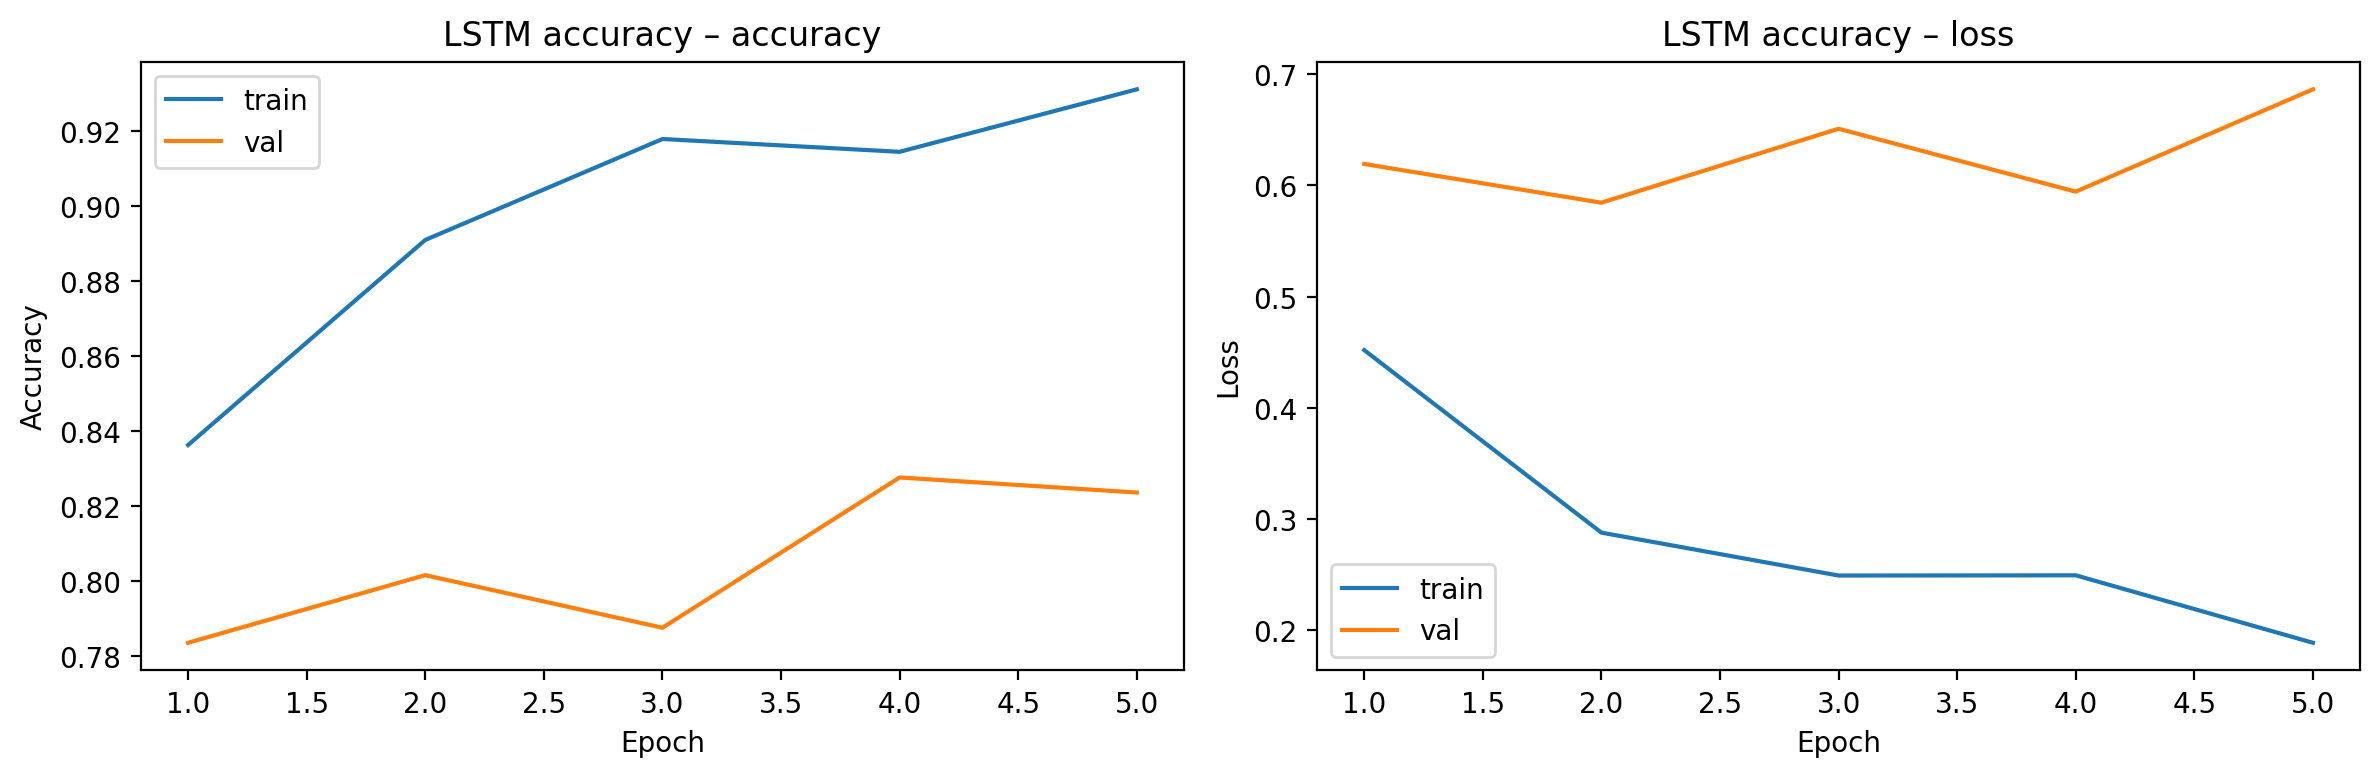

In [22]:
plot_curves(history_lstm,  "LSTM accuracy")

**Summary Highlights:**

* Training accuracy climbs to about 0.93 and loss keeps falling &rarr; the model fits the training set well.
* Validation accuracy tops out near 0.83 around epoch 4 and then plateaus.
* Validation loss trends upward while training loss drops &rarr; classic overfitting after ~epoch 3-4.
* Best checkpoint is likely from epoch 3-4; use early stopping there.
* If we want more headroom: we would raise dropout or recurrent dropout, trim units/layers, or add attention/regularization and data augmentation.


## **LSTM Performance Evaluation**



In [23]:
test_acc = best_lstm.evaluate(test_roll, verbose=0)[1]
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.830


              precision    recall  f1-score   support

        Bach      0.791     0.895     0.840       114
   Beethoven      0.759     0.802     0.780       126
      Chopin      0.874     0.898     0.886       108
      Mozart      0.909     0.753     0.824       146

    accuracy                          0.830       494
   macro avg      0.833     0.837     0.832       494
weighted avg      0.836     0.830     0.830       494



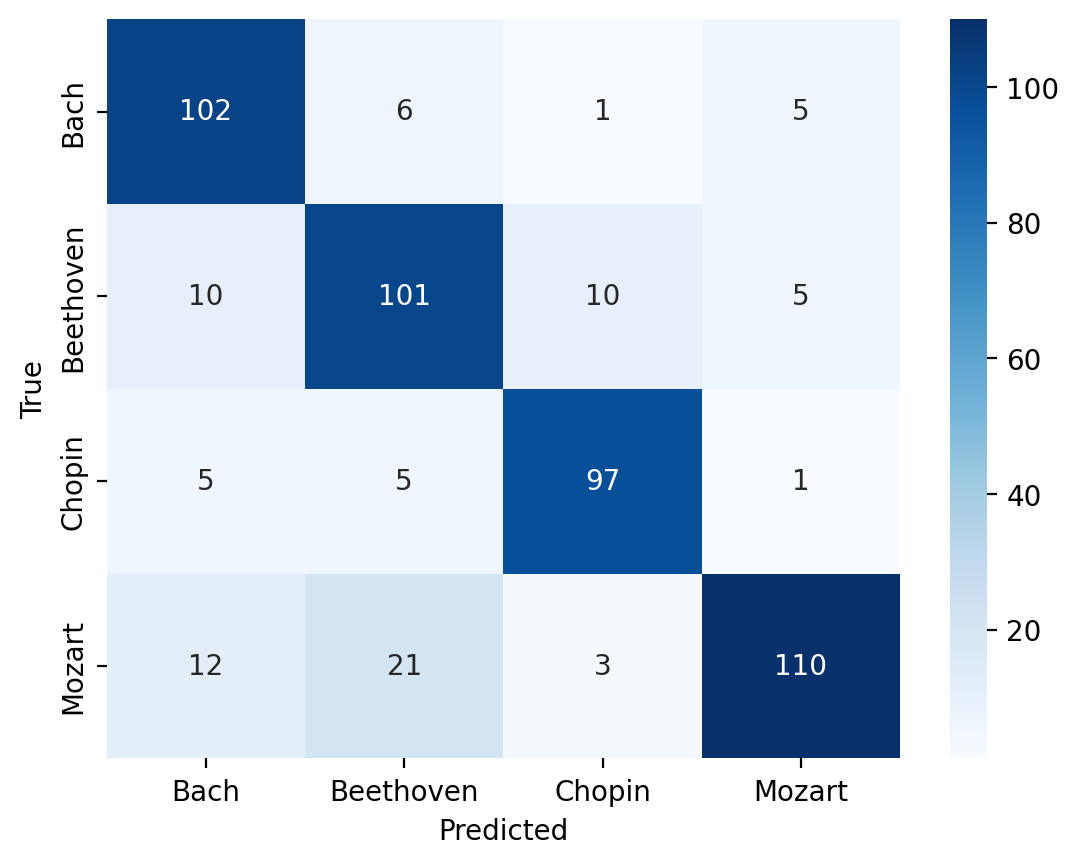

In [24]:
y_true = np.concatenate([y for _, y in test_roll])
y_pred = np.argmax(best_lstm.predict(test_roll, verbose=0), axis=1)
labels = sorted(df["composer"].unique())

print(classification_report(y_true, y_pred, target_names=labels, digits=3))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

**LSTM Performance - Summary Highlights:**

* **Overall**: test accuracy **0.830** on 494 pieces.
* **Strong classes**
  * **Chopin**: best f1 (0.886). High precision and recall; few confusions.
  * **Bach**: high recall (0.895). Most Bach pieces are caught.
*  **Harder classes**
  * **Mozart**: high precision (0.909) but lower recall (0.753). Misses mostly to **Bach** and **Beethoven**.
  * **Beethoven**: lowest f1 (0.780). Confused with **Bach** and **Chopin**.
* **Averages**: macro precision **0.833**, macro recall **0.837**, macro f1 **0.832**.
* **Confusion patterns**
  *  Mozart &rarr; Bach/Beethoven is the main error path.
  * Beethoven &harr; Chopin shows symmetric spillover.
  * Bach is rarely mistaken for Chopin or Mozart.

**Takeaway**: the model captures composer style well overall; adding a bit more regularization or targeted augmentation for Beethoven and Mozart should reduce the remaining confusion.


## **Saving LSTM Model**

In [25]:
# local SavedModel directory:
MODEL_DIR = Path("/content/models/best_lstm")     # no extension
best_lstm.export(MODEL_DIR)      # creates a folder

# Lightweight .keras bundle:
KERAS_FILE = Path("/content/models/best_lstm.keras")
best_lstm.save(KERAS_FILE)

# copy to Google Drive:
drive_dst = Path("/content/drive/My Drive/Colab Notebooks/maestro_models_v2")
drive_dst.mkdir(parents=True, exist_ok=True)

# copy / overwrite SavedModel folder:
dst_folder = drive_dst / MODEL_DIR.name
if dst_folder.exists():
    shutil.rmtree(dst_folder)
shutil.copytree(MODEL_DIR, dst_folder)

# copy .keras file:
shutil.copy2(KERAS_FILE, drive_dst / KERAS_FILE.name)

print("Saved to", drive_dst)

Saved artifact at '/content/models/best_lstm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 88), dtype=tf.float32, name='pianoroll')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132037479422608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132037478911440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132037478909520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132037478915088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132049195556240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132049195557776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132037478914896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132049195555472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132049195564496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132049195564304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132049195563